# Tracing career histories of film directors from IMDb data
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

Welcome to our journey through the world of film, where we aim to unravel the mysteries behind the careers of movie directors! This notebook details the first steps towards understanding if and how connections with network brokers might enable women movie directors to enjoy longer and more impactful careers, and how these effects compare with their men counterparts. 

**What are we aiming to do?**

At this stage, our goal is to build a dataset of all movies released from 2000 to 2023. This dataset will be the backbone for constructing dynamic collaboration networks of filmmakers, with each snapshot of the network capturing their collaboration ties within every three-year period.

Wel'll also construct a unique dataset of movie directors who made their debut from 2003 to 2013. We'll compile their filmographies up to 2023. This way, we ensure that we have at least a decade's view into each director's journey.

Lastly, we'll delve deeper into the pre- and post-debut career paths of these directors. Specifically, we count the number of movies they went on to direct after their debut. We'll also examine their industry involvement before becoming directors. This gives us a sense of how prior experiences in different filmmaking roles may shape their directorial paths.

**Looking ahead**

These analyses lays the ground work for the second phase: calculating the levels of brokerage social capital of our directors and their collaborators over time.

# Building dataset of movies released between 2000 and 2023 

In this section of the notebook, we will build a comprehensive dataset of movies released between 2000 and 2023.

Before diving into the data analysis, we need to set up our working environment. This includes importing necessary Python libraries and setting the working directory. These steps ensure that we can run our code smoothly and manage our files efficiently.

In [18]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import os 
from collections import defaultdict
import seaborn as sns
from wordcloud import WordCloud

# Setting the working directory to where project files are located.
# This helps in organizing project files and ensures relative paths work correctly.
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

We'll be using two key datasets from IMDb: 'title.basics.tsv.gz' for basic movie information and 'title.principals.tsv.gz' for information on key contributors to each movie. These datasets will serve as the foundation for our analysis, allowing us to explore the structure of collaboration networks in the film industry.

In [8]:
# Defining URLs of the IMDb data files.
# IMDb provides open datasets for basic title information and title principals (major contributors).
url_basics = 'https://datasets.imdbws.com/title.basics.tsv.gz'
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'

# Loading the datasets directly from IMDb's servers.
# This approach ensures we're working with the most up-to-date information available.
# The datasets are in TSV (Tab-Separated Values) format and compressed with gzip.
df_basics = pd.read_csv(url_basics, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)
df_principals = pd.read_csv(url_principals, sep='\t', compression='gzip', encoding='utf-8', low_memory=False)

After loading the data, our next step is to clean and prepare it for analysis. This involves filtering out irrelevant entries (such as TV shows and adult movies) and ensuring that our dataset only includes movies with valid release years. 

In [40]:
# Displaying the first few rows of the 'df_basics' DataFrame to understand the structure of the dataset.
# This initial look helps in planning how to filter and process the data for our analysis.
df_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,\N,1,"Comedy,Short"


In [41]:
# Analyzing the distribution of values in 'titleType' and 'isAdult' columns.
# Understanding these distributions is crucial for filtering the dataset to movies only and excluding adult content.
{col: df_basics[col].value_counts() for col in ['titleType', 'isAdult']}

{'titleType': titleType
 tvEpisode       8042282
 short            974875
 movie            669892
 video            287189
 tvSeries         256237
 tvMovie          144193
 tvMiniSeries      52188
 tvSpecial         45647
 videoGame         37276
 tvShort           10240
 tvPilot               1
 Name: count, dtype: int64,
 'isAdult': isAdult
 0       10185807
 1         334195
 2023           6
 2019           3
 2020           2
 1981           1
 2017           1
 \N             1
 2022           1
 2011           1
 2014           1
 2005           1
 Name: count, dtype: int64}

In [9]:
# Converting 'startYear' column to numeric values.
# Non-numeric entries (errors) are converted to NaN (Not a Number), which simplifies filtering later on.
df_basics['startYear'] = pd.to_numeric(df_basics['startYear'], errors='coerce')

# Filtering the dataset to include only non-adult movies with a valid start year.
# This step is essential for focusing our analysis on relevant movies.
movies = (df_basics
          .query('titleType == "movie" & isAdult == "0" & startYear == startYear') 
          .filter(items=['tconst', 'startYear', 'genres'])  
          )

# Displaying the number of unique values in each column of the 'movies' DataFrame
movies.nunique()

tconst       563624
startYear       135
genres         1338
dtype: int64

As of the time of this analysis (Jan 29, 2024), the data includes 563,624 non-pornographic movies spaning 135 years. What are the earlies and latest year we have in the data?

In [10]:
# Determining the range of years covered in our filtered dataset.
# This information helps in understanding the temporal span of our data.
print("Earliest Year:", movies['startYear'].min())
print("Latest Year:", movies['startYear'].max())

Earliest Year: 1894.0
Latest Year: 2031.0


The earliest year we have data on is 1894 and the latest year 2031. Seems like IMDb also has info on movies that have not been released yet. Let’s remove these future movies. And then, with our dataset ready, we'll visualize trends in movie production over time. Visualizing the number of movies released each year will help us understand how the movie industry has evolved and identify any significant patterns or anomalies.

In [ ]:
# Excluding movies released after 2023 to align with the study's timeframe.
movies = movies[movies['startYear'] <= 2023]

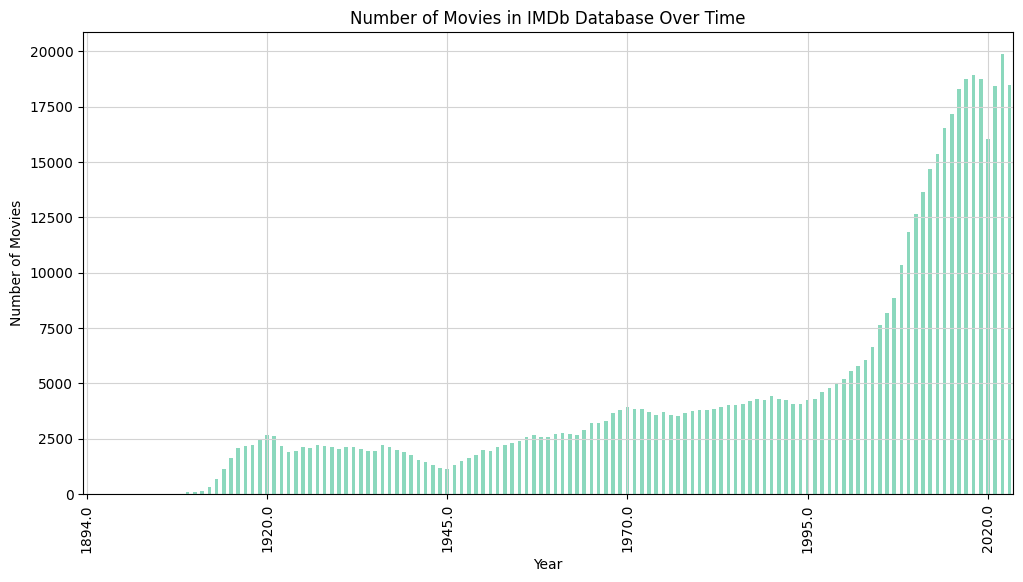

In [74]:
# Aggregating the number of movies released each year.
# This aggregation helps in visualizing trends in movie production over time.
movies_per_year = movies.groupby('startYear').size()

# Plotting the annual movie counts to visually analyze trends in movie production.
plt.figure(figsize=(12,6))
movies_per_year.plot(kind='bar', color='#8BD8BD')
plt.title('Number of Movies in IMDb Database Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(range(0, len(movies_per_year), 25), labels=movies_per_year.index[::25]) # Adjust x-axis to show labels for every 25 years
plt.grid(True, color='#D3D3D3')  # Adding light grey grid lines for better readability
plt.show()


A lot more movies are made in the 21st century than previous centuries. This is probably due to the spread of the internet in the late 90s, which led to a significant shift towards digital filmmaking and distribution. This technological advancement made it easier and more cost-effective to produce and distribute films. That's likely one of the reasons why we saw an increase in the number of movies released annually. Our study will focus on movies released in this century, i.e., from 2000 to 2023 (present year).

In [30]:
# Narrowing down the dataset to include movies released from 2000 to 2023.
# This will serve as the data to build the film-maker collaboration network later on
movies_2000_2023 = movies[(movies['startYear'] >= 2000) & (movies['startYear'] <= 2023)]

# Displaying the first few rows of this subset
movies_2000_2023.head()

,tconst,startYear,genres
11634,tt0011801,2019.0,"Action,Crime"
13079,tt0013274,2021.0,Documentary
15174,tt0015414,2000.0,\N
27745,tt0028248,2022.0,Musical
34798,tt0035423,2001.0,"Comedy,Fantasy,Romance"


In [31]:
# Counting unique values in each column of our final dataset.
# This step provides insights into the diversity of data we'll be working with.
movies_2000_2023.nunique()

tconst       313675
startYear        24
genres         1192
dtype: int64

We now have 313,675 movies made between 2000 and 2023, with information on each movie's ID (`tconst`), release year (`startYear`), and genres (`genres`). Before moving on to the next stage of analysis, we save this dataset to a CSV file so that we can use it later to construct a dynamic collaboration network among film-makers from 2000 to 2023. 

In [32]:
# Saving the DataFrame to a CSV file for future use
# 'index=False' omits the index column in the saved file
movies_2000_2023.to_csv('movies_2000_2023.csv', index=False)

# Visualization to understand movies data better 

Let's also create som visualizations to explore different aspects of the movies released in this period, from number of movie releases to genre popularity.

First, let's visualize the number of movie releases over time. 

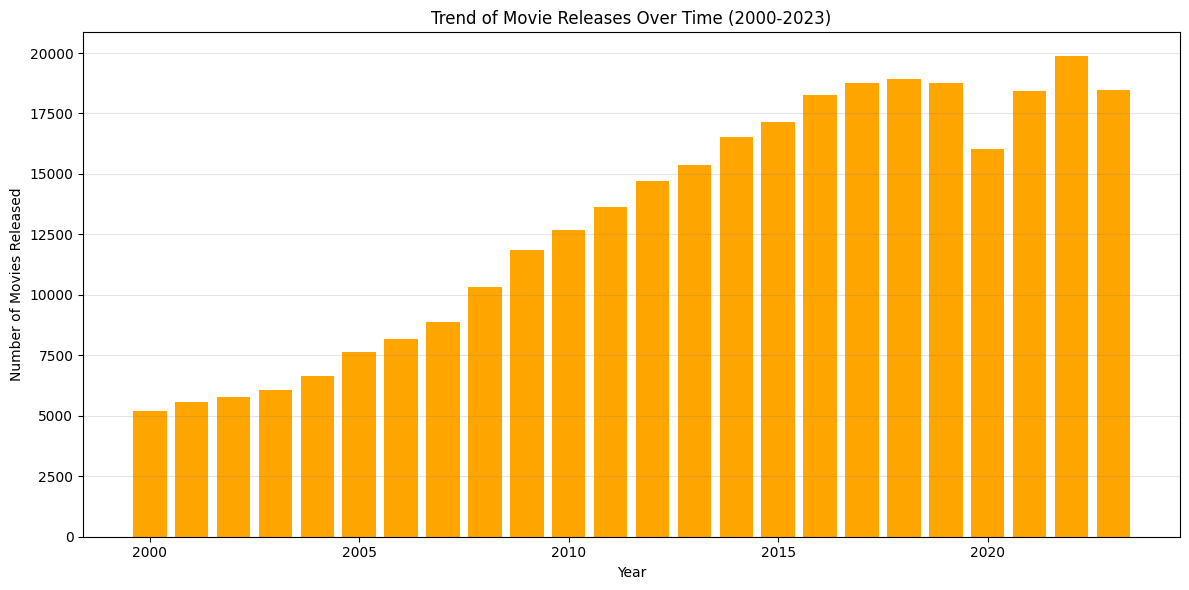

In [6]:
# Group by startYear and count the number of movies
movies_by_year = movies_2000_2023.groupby('startYear').size()

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(movies_by_year.index, movies_by_year.values, color='orange')
plt.title('Trend of Movie Releases Over Time (2000-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.grid(axis='y', color='grey', alpha=0.2)
plt.tight_layout()
plt.show()

The number of movie releases steadily increases every year, except for in 2020 where we see a dip. This is probably due to the COVID-19 pandemic that began in late 2019 and continued into the following years. Many movie productions were paused, and theaters closed, leading to a significant decrease in movie releases in 2020. However, in 2021, the number of movie releases went up again and by 2023, it is now at the levels before the pandemic. This is partly thanks to the shift towards streaming platforms, introducing a new venue for film debuts.

It is also interesting to see that the 2007-2008 Writers Guild of America strike and the 2008 economic recession did not seem to have a dampening effect on the number of movie releases, with this number still rising annually throughout this period. 

Next, let's visualize the distribution of movie genres across all years in the data. For this, we'll calculate the percentage of movies in each genre relative to the total number of movies released and then use a donut chart identifying the most common genres.

In [ ]:
# Prepare the data for 100% stacked bar chart

# Split genres into lists for filtering
movies_2000_2023['genres'] = movies_2000_2023['genres'].str.split(',')

# Filter out 'Short' and 'Adult' from genre lists
movies_2000_2023['genres'] = movies_2000_2023['genres'].apply(lambda genres: [genre for genre in genres if genre not in ['Short', 'Adult']])

# Some movies might now have empty genre lists; let's filter those out as well
movies_2000_2023 = movies_2000_2023[movies_2000_2023['genres'].map(bool)]

# Expanding the genres so each genre is treated separately
expanded_genres = movies_2000_2023.explode('genres')

# Remove movies with '\N' genre (which represents missing data)
expanded_genres = expanded_genres[expanded_genres['genres'] != '\\N']

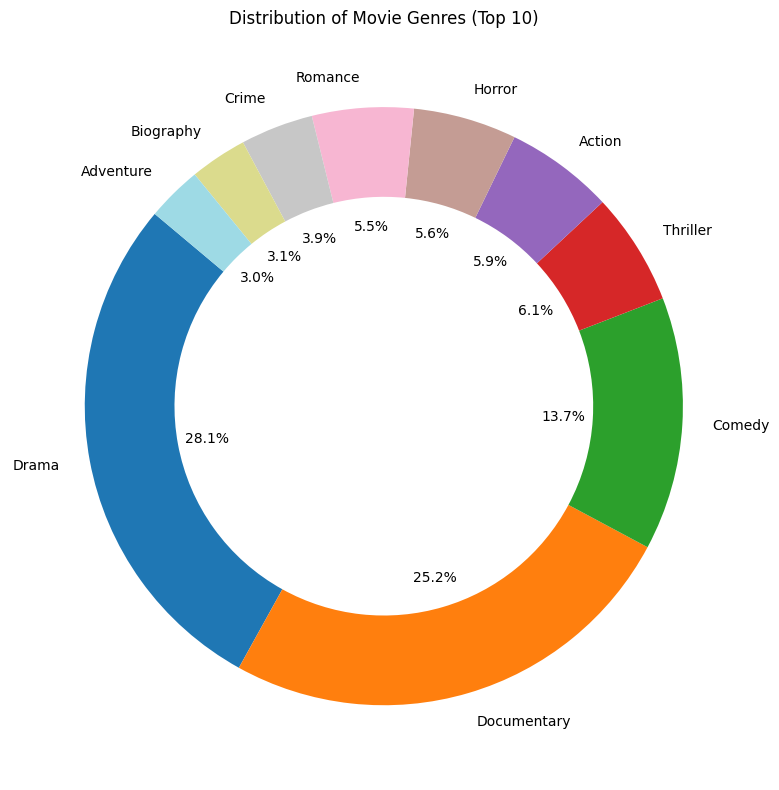

In [64]:
# Calculate the distribution of genres across all years
genre_distribution = expanded_genres['genres'].value_counts(normalize=True) * 100

# Select the top genres for visualization to avoid clutter
top_genres = genre_distribution.head(10)

# Generate unique colors for each genre
unique_colors = plt.cm.tab20(np.linspace(0, 1, len(top_genres)))

# Plotting Donut Chart by adding 'wedgeprops'
plt.figure(figsize=(8, 8))
plt.pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', startangle=140, colors=unique_colors, wedgeprops=dict(width=0.3))
plt.title('Distribution of Movie Genres (Top 10)')

plt.tight_layout()
plt.show()


It seems like drama, documentary, and comedy are the most popular genres. 

In addition to donut chart, we can also use word cloud to visualize the distribution of genres within the dataset, where the size of each genre's name corresponds to its frequency. The larger the genre name appears in the Word Cloud, the more frequently it occurs in the dataset, indicating its popularity or commonality in movie production. 

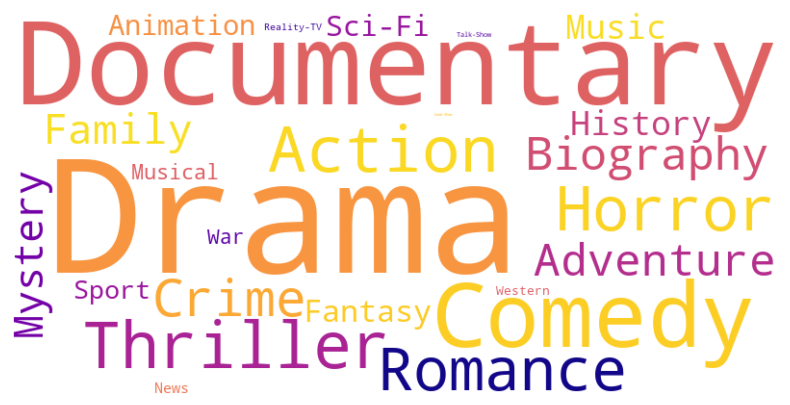

In [62]:
# Calculate the frequency of each genre in the dataset
genre_frequencies = expanded_genres['genres'].value_counts().to_dict()

# Create a word cloud using the frequencies dictionary
wordcloud = WordCloud(width=800, height=400, background_color ='white', colormap='plasma').generate_from_frequencies(genre_frequencies)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.show()

Let's see if the most popular genres over time. For this, we'll create three donut charts, each corresponding to a different decade: the 2000s (2000-2009), the 2010s (2010-2019), and the early 2020s (2020-2023). Placed in a single row, these charts allow for a direct comparison of movie genre distributions across the three distinct periods, highlighting how the popularity of top genres has evolved over the past two-plus decades.

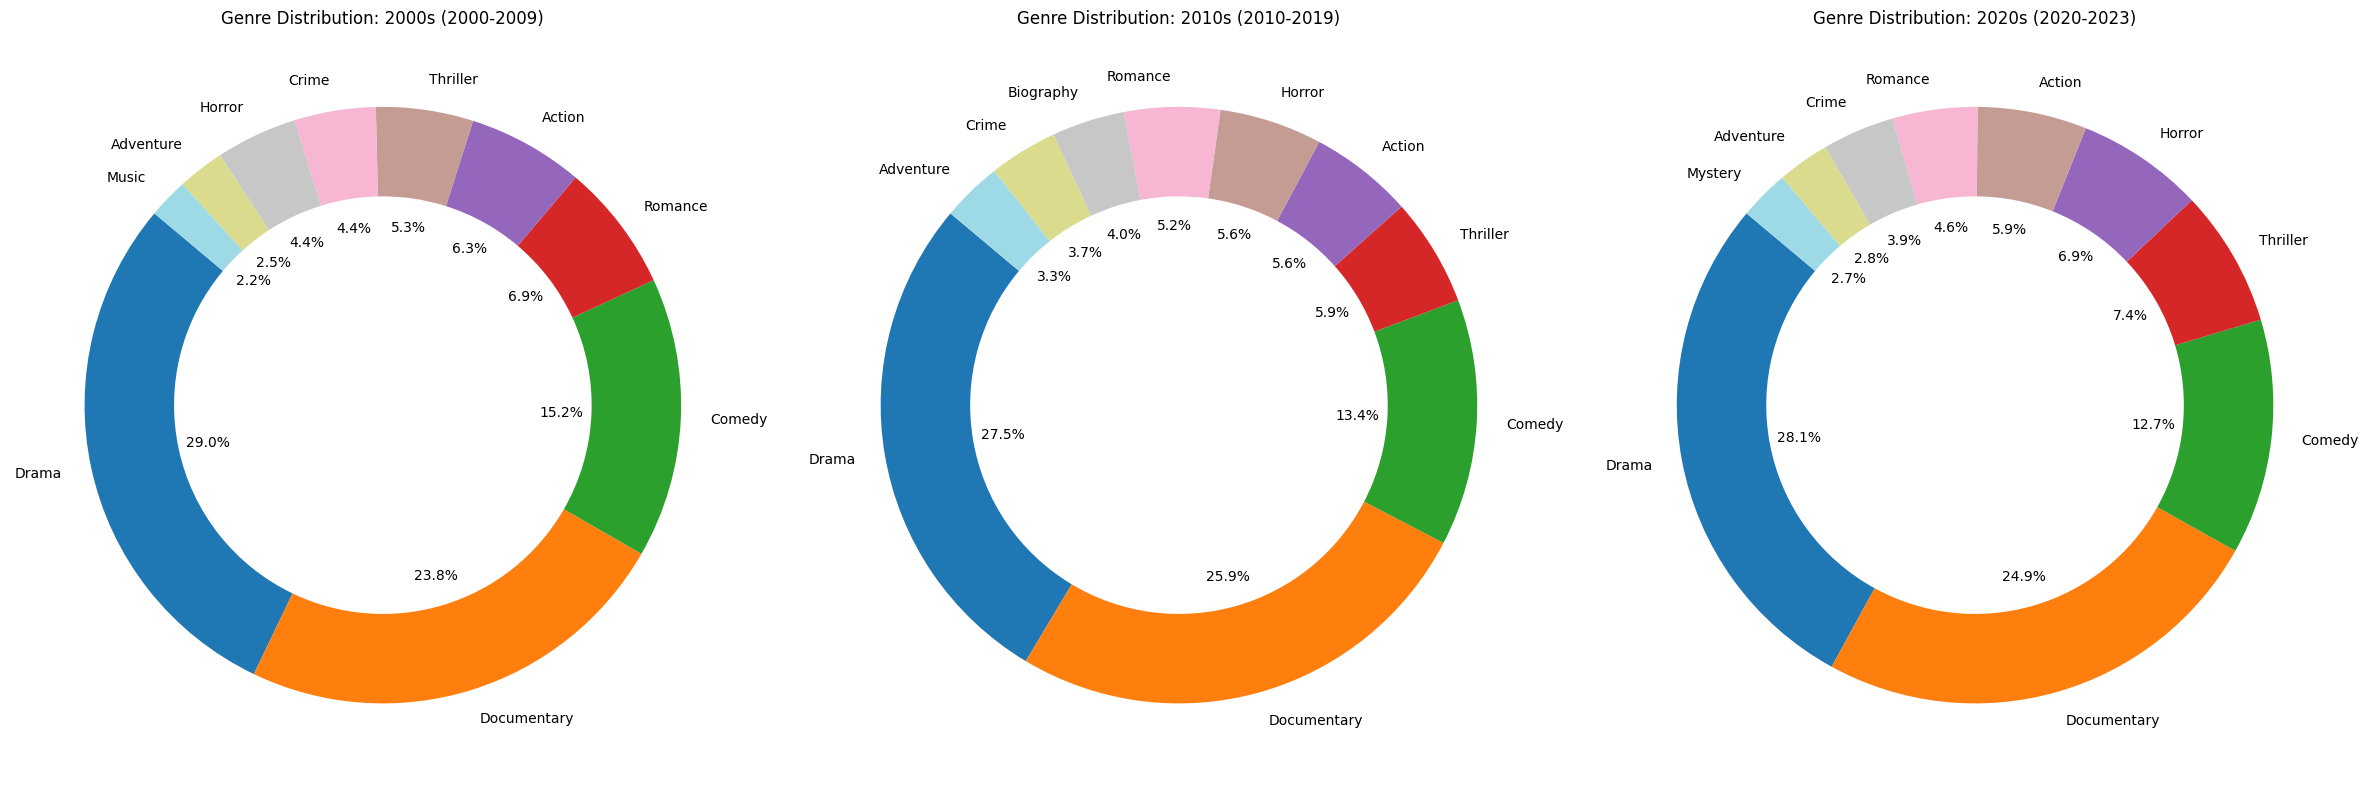

In [48]:
# Define the consolidated time periods for the new set of donut charts
consolidated_periods = {
    '2000s (2000-2009)': (2000, 2009),
    '2010s (2010-2019)': (2010, 2019),
    '2020s (2020-2023)': (2020, 2023),
}

# Prepare the figure for the donut charts, ensuring they're all on one row
fig, axs = plt.subplots(1, len(consolidated_periods), figsize=(24, 8))  # One row, with a subplot for each time period

for idx, (period_label, (start_year, end_year)) in enumerate(consolidated_periods.items()):
    # Filter the data for the current period
    period_data = expanded_genres[(expanded_genres['startYear'] >= start_year) & (expanded_genres['startYear'] <= end_year)]
    
    # Calculate genre distribution for the current period
    genre_distribution_period = period_data['genres'].value_counts(normalize=True) * 100
    top_genres_period = genre_distribution_period.head(10)
    
    # Generate unique colors for each genre
    unique_colors_period = plt.cm.tab20(np.linspace(0, 1, len(top_genres_period)))
    
    # Plotting Donut Chart for the current period
    axs[idx].pie(top_genres_period, labels=top_genres_period.index, autopct='%1.1f%%', startangle=140, colors=unique_colors_period, wedgeprops=dict(width=0.3))
    axs[idx].set_title(f'Genre Distribution: {period_label}')

# Adjust layout and display
plt.tight_layout()
plt.show()

It seems like Drama, Documentary, and Comedy remain the most popular genres over time. Although there seems to be some fluctuations, for example, the fourth and fifth most popular genres in the 2000s are Comedy and Romance, while in the 2010s they are Thriller and Action (reflecting the rise of superhero movies and the decline of romantic comedy movies?). In the early 2020s, they are Thriller and Horror.

To understand exactly how much different genres have evolved in popularity between the years 2000 and 2023, let's create a bar chart with genres that have seen an increase in percentage displayed on the left and those with a decrease on the right. Each bar represents a different genre, with the length of the bar indicating the magnitude of the change in percentage. Blue bars denote increases in popularity, while red bars indicate decreases. The central line at the 0 point on the x-axis serves as a reference point, making it easy to discern the direction of change for each genre.

In [25]:
# Count the number of movies in each genre per year
genre_counts_per_year = expanded_genres.groupby(['startYear', 'genres']).size().unstack(fill_value=0)

# Calculate the percentage of movies in each genre relative to the total number of movies released that year
genre_percentages_per_year = genre_counts_per_year.div(genre_counts_per_year.sum(axis=1), axis=0) * 100

# Calculate the first and last year percentage for comparison
first_year_percentage = genre_percentages_per_year.iloc[0]
last_year_percentage = genre_percentages_per_year.iloc[-1]

# Calculate the change in percentage for each genre between 2000 and 2023
percentage_change = last_year_percentage - first_year_percentage

# Sort genres by the change to ensure a coherent plot
percentage_change_sorted = percentage_change.sort_values()

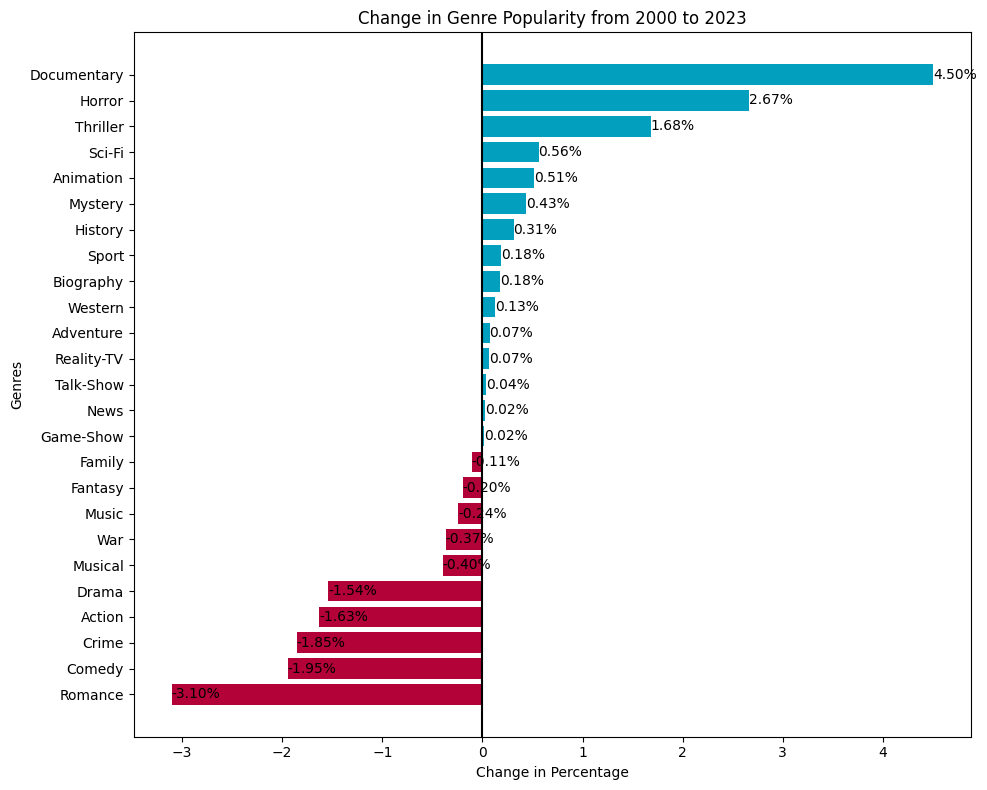

In [32]:
# Plotting
plt.figure(figsize=(10, 8))
bars = plt.barh(percentage_change_sorted.index, percentage_change_sorted.values, color=np.where(percentage_change_sorted > 0, '#039fbe', '#b20238'))
plt.axvline(0, color='black', linewidth=1.5)  # Line at the 0 point on the x-axis
plt.title('Change in Genre Popularity from 2000 to 2023')
plt.xlabel('Change in Percentage')
plt.ylabel('Genres')

# Adding labels to indicate increase or decrease
for bar in bars:
    width = bar.get_width()
    label_x_pos = bar.get_width() if bar.get_width() < 0 else bar.get_width()
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, f"{'%.2f' % width}%", va='center')

plt.tight_layout()
plt.show()

Looks like Documentaries, Horror, and Thriller have seen an increase in popularity over the years, while Action, Comedy, Crime, Drama, and Romance have seen a decrease in their relative popularity. The rest of the genres have remained relatively stable.

To have a clear comparison of their changing percentages, we can create a grouped bar chart with bars for each genre next to each other for the years 2000 and 2023. This chart will have two main groups — one for genres with rising popularity and another for those with declining popularity. 

In [34]:
# Genres identified for analysis
rising_genres = ['Documentary', 'Horror', 'Thriller']
falling_genres = ['Action', 'Comedy', 'Crime', 'Drama', 'Romance']

# Extract the percentages for the selected genres in 2000 and 2023
genres_selected = rising_genres + falling_genres
percentages_2000_2023 = genre_percentages_per_year.loc[[2000, 2023], genres_selected].transpose()

# Create a new DataFrame to simplify plotting
plot_data = percentages_2000_2023.stack().reset_index()
plot_data.columns = ['Genre', 'Year', 'Percentage']

# Unique genres and years for plotting
unique_genres = plot_data['Genre'].unique()
years = plot_data['Year'].unique()

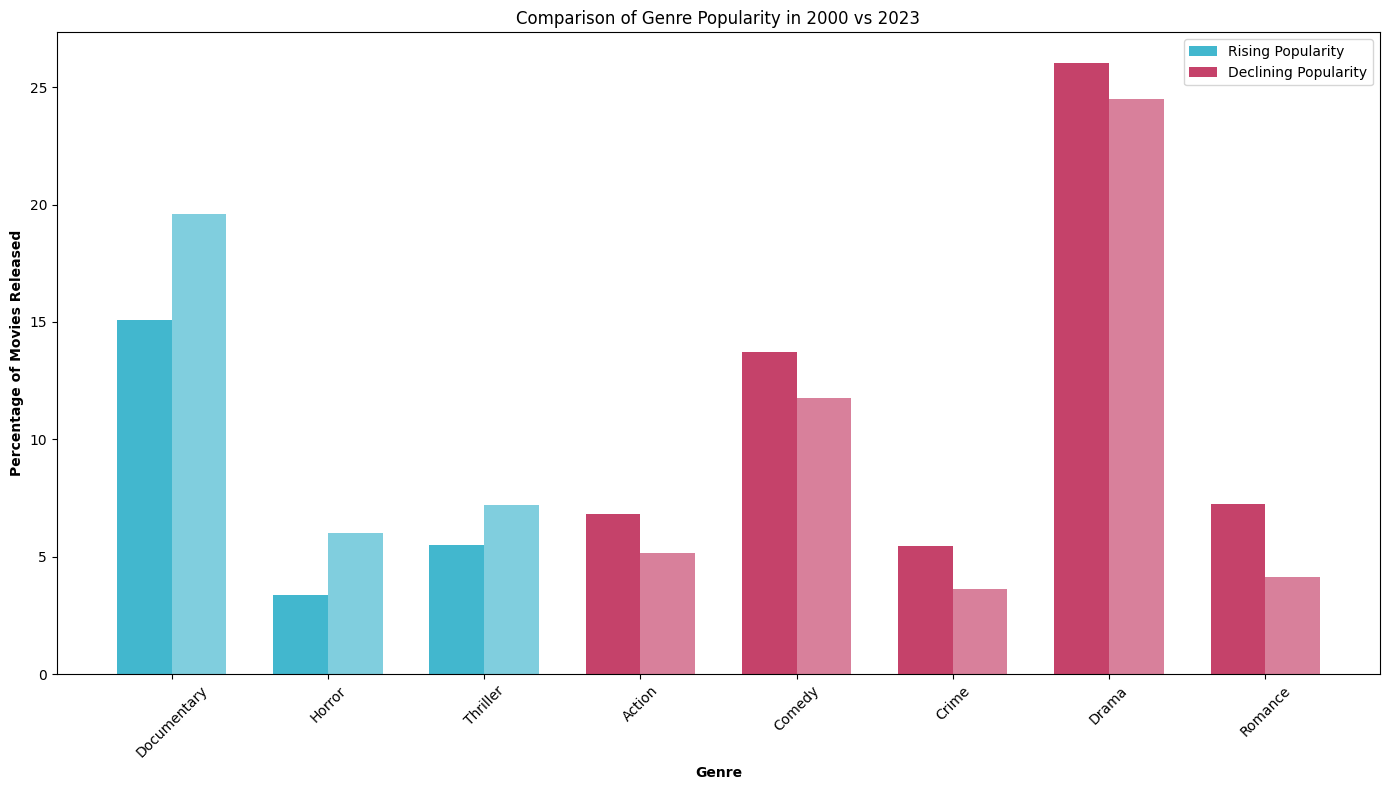

In [40]:
# Position of bars on the x-axis
barWidth = 0.35

# Define positions for each group of bars
positions_2000 = np.arange(len(unique_genres))
positions_2023 = positions_2000 + barWidth

# Repeating the plotting logic with the import correction for the legend
fig, ax = plt.subplots(figsize=(14, 8))

# Plot bars for 2000 and 2023 with corrected positions and differentiated colors
for i, genre in enumerate(unique_genres):
    percentage_2000 = plot_data[(plot_data['Year'] == 2000) & (plot_data['Genre'] == genre)]['Percentage'].values
    percentage_2023 = plot_data[(plot_data['Year'] == 2023) & (plot_data['Genre'] == genre)]['Percentage'].values
    color = '#039fbe' if genre in rising_genres else '#b20238'  # Blue for rising, red for falling
    
    ax.bar(positions_2000[i], percentage_2000, color=color, width=barWidth, label=genre if i == 0 else "", alpha=0.75)
    ax.bar(positions_2023[i], percentage_2023, color=color, width=barWidth, alpha=0.5)

# Customize the plot
ax.set_xlabel('Genre', fontweight='bold')
ax.set_ylabel('Percentage of Movies Released', fontweight='bold')
ax.set_title('Comparison of Genre Popularity in 2000 vs 2023')
ax.set_xticks(positions_2000 + barWidth / 2)
ax.set_xticklabels(unique_genres, rotation=45)

# Correct legend
legend_elements = [Patch(facecolor='#039fbe', label='Rising Popularity', alpha=0.75),
                   Patch(facecolor='#b20238', label='Declining Popularity', alpha=0.75)]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

We can see that although the percentage of Drama movies has decreased over time, this genre is still extremely popular, presenting one fourth of all movies released in 2023. Same for Comedy, to a lesser extent, given that 12 % of all 2023 movies have this genre.

We can also get a sense of which genres have more consistent popularity and production levels versus those with more sporadic peaks and wider distribution ranges. For this, we use a violin plot to compare the distribution of the number of movies released across different genres. 

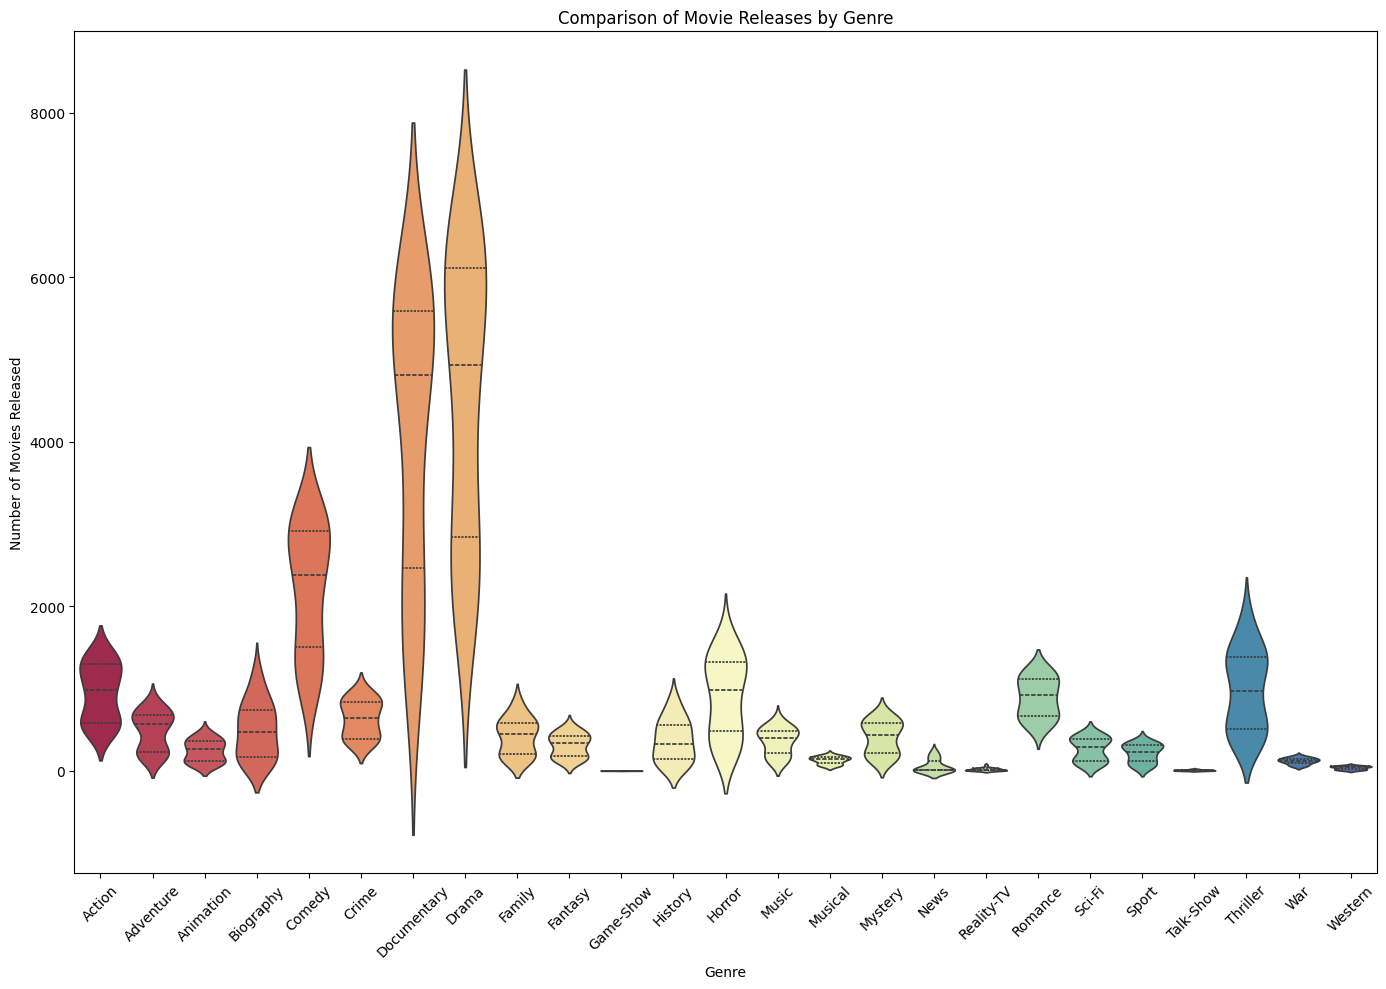

In [54]:
# visualize the comparison of movie releases by genre using a violin plot
# Group the data by genre and startYear, then count the number of releases
genre_year_distribution = expanded_genres.groupby(['genres', 'startYear']).size().reset_index(name='MovieCount')

# Now let's create the violin plot using Seaborn for a better aesthetic and functionality for this type of visualization

plt.figure(figsize=(14, 10))
sns.violinplot(data=genre_year_distribution, x='genres', y='MovieCount', density_norm='width', inner='quartile', palette="Spectral",
               hue='genres', legend=False)
plt.xticks(rotation=45)
plt.title('Comparison of Movie Releases by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies Released')
plt.tight_layout()
plt.show()

The genres with highest variability (those with broad violins at the median and long tails) are Drama, Documentary, and, to a lesser extent, Comedy. This means that they have had years of both high and low productions, indicating fluctuations in popularity. Despite their high variability, they remain highly popular, indicated by high median values of movies per year. This means there were a strong, sustained interest in these genres over time.

Action, Horror, Romance, and Thriller, while not topping the list in median releases, show significant production levels with high median releases, indicating its steady popularity.

Genres with stable production levels (those with narrow and more uniform violins) are Game-Show, Talk-Show, Reality-TV, indicating that they maintain a steady presence in the industry over time. 

Ok now that we understand the movie data a bit better, let's move on to the next phase of the project - building a dataset covering the full filmography of movie directors. 

# Identifying first-time directors and tracking full filmography 

In this section of our notebook, we identify film directors who made their debut between 2003 and 2013. This period is particularly fascinating due to the evolving landscape of the film industry, marked by the rise of digital filmmaking and the changing dynamics of global cinema due to the spread of the internet in the late 90s. By compiling the full filmography of these directors, we can in later analysis uncover patterns in their career progressions, the genres they explore, and how their work is received by audiences.

Our first step is to delve into the `df_principals` DataFrame, which provides a comprehensive list of key contributors to films listed in the IMDb database. Understanding the structure of this dataset is crucial, as it allows us to isolate directors - the main focus of our study. 

In [42]:
# Initial Exploration of Principal Contributors Data
# The 'df_principals' DataFrame contains key contributors to movies, including directors, actors, etc.
# Viewing its structure helps us understand how to extract information specific to directors.
df_principals.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


Let's also examine the frequency of different roles, which gives us a sense of the diversity of contributions within film production and helps precisely target the roles relevant to our analysis.

In [43]:
# Understanding the Roles in Film Production
# By analyzing the 'category' column, we identify the distribution of different roles within movie productions.
# This is crucial for isolating directors from other types of contributors in the dataset.
df_principals['category'].value_counts()

category
actor                  13322849
self                   10448069
actress                10392402
writer                  8435856
director                6951076
producer                3917208
cinematographer         2050878
editor                  1996902
composer                1996779
archive_footage          397891
production_designer      381792
archive_sound              4516
Name: count, dtype: int64

The data includes information on who (`nconst`) worked on which movie (`tconst`) in which capacity (`category`). We'll filter the DataFrame to include only directors. We then merge this information with the `movies` DataFrame to link directors to their films. Furthermore, by determining the debut year of these directors, we can identify those who started their journey in the years between 2003 and 2013.

With the list of directors debuting in our period of interest, we proceed to compile their full filmographies. This data is crucial for subsequent analysis into how their careers are shaped by their gender and professional ties to other film-makers.

In [37]:
# Isolating Directors
# We filter 'df_principals' to focus only on entries categorized as 'director'.
# This step is essential for later linking directors to their respective movies.
directors = df_principals[df_principals['category'] == 'director']

# Linking Directors to Their Movies
# We merge the 'movies' DataFrame with the filtered 'directors' DataFrame using the 'tconst' identifier.
# This enables us to attribute movies to specific directors 
directors = movies.merge(directors[['tconst', 'nconst']], on='tconst', how='inner')

# Identifying Directors' Debut Films
# By grouping the data by director and finding the earliest 'startYear', we identify each director's debut film.
directors_first_movies = directors.groupby('nconst').agg({'startYear': 'min'}).reset_index()

# Renaming the aggregated column to denote it as the year of the director's first movie
directors_first_movies = directors_first_movies.rename(columns={'startYear': 'firstYear'})

# Focusing on Directors Who Debuted Between 2003 and 2013
# We filter directors to include only those whose debut falls within our period of interest.
# This selection allows us to have at least a decade view into a director's career
debut_directors_2003_2013 = directors_first_movies[(directors_first_movies['firstYear'] >= 2003) & (directors_first_movies['firstYear'] <= 2013)]

# Compiling Full Filmographies
# By filtering the 'directors' DataFrame for our identified debut directors, we compile their complete filmographies.
directors_full_filmography = directors[directors['nconst'].isin(debut_directors_2003_2013['nconst'])]

# Merging with debut information allows us to retain knowledge of each director's first year in the industry.
directors_full_filmography = directors_full_filmography.merge(debut_directors_2003_2013, on='nconst', how='left')

In [55]:
# Counting the unique counts for an overview of the compiled filmographies
directors_full_filmography.nunique()

tconst       115413
startYear        21
genres          948
nconst        63169
firstYear        11
dtype: int64

As seen above, our sample includes 63,169 directors. Let's count the number of movies each director made in their debut year to get a sense of their early outputs.

In [22]:
# Analyzing Directors' Output in Their First Year
# We isolate movies directed in the directors' debut year and count the movies they directed in that year.
first_year_movies = directors_full_filmography[directors_full_filmography['startYear'] == directors_full_filmography['firstYear']]
movies_count_first_year = first_year_movies.groupby('nconst').size()
movies_count_first_year.value_counts().sort_index()

1    61775
2     1276
3       83
4       22
5        7
6        3
7        2
Name: count, dtype: int64

Looks the majority (98%) of directors in our sample directed only one movie in their first year, but a small group of directors did make more than one movie the year they started directing. 

To further enrich our understanding of the works of these directors, we integrate IMDb ratings and vote counts into our filmography dataset. This step allows us to gauge the popularity and reception of each movie directed by our cohort of first-time directors. 

In [56]:
# Integrating IMDb Ratings
# Accessing and merging IMDb's 'title.ratings' dataset enhances our filmography data with public reception metrics.
# This inclusion of ratings and votes offers an additional layer of analysis for evaluating directors' works.
url_ratings = 'https://datasets.imdbws.com/title.ratings.tsv.gz'
df_ratings = pd.read_csv(url_ratings, sep='\t', compression='gzip')

# Displaying the first few rows of 'df_ratings' for an overview
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2017
1,tt0000002,5.7,270
2,tt0000003,6.5,1943
3,tt0000004,5.4,178
4,tt0000005,6.2,2721


In [57]:
# Merge the ratings data with the 'directors_full_filmography' dataset
# This adds IMDb ratings and number of votes to the filmography data
directors_full_filmography = directors_full_filmography.merge(df_ratings, on='tconst', how='left')

# Save the 'directors_full_filmography' dataset to a CSV file for future use
directors_full_filmography.to_csv('directors_full_filmography.csv', index=False)

In [3]:
directors_full_filmography = pd.read_csv("directors_full_filmography.csv")

In [4]:
directors_full_filmography

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004.0,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004.0,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003.0,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008.0,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005.0,Drama,nm0000417,2005.0,5.3,950.0
...,...,...,...,...,...,...,...
128529,tt9916362,2020.0,"Drama,History",nm1893148,2008.0,6.4,5687.0
128530,tt9916538,2019.0,Drama,nm4457074,2011.0,8.6,7.0
128531,tt9916622,2015.0,Documentary,nm9272490,2012.0,NaN,NaN
128532,tt9916754,2013.0,Documentary,nm9272490,2012.0,NaN,NaN


# Visualization to understand director filmography better 

# Examining career pre- and post-directing debut

In this section, we delve into the work of these directors before and after their directorial debut.

## Career progression post-debut:

First, let's count the number of movies they directed after their debut. This helps us understand the career trajectory of first-time movie directors following their initial foray into directing. 

In [67]:
# Initialize a DataFrame to analyze the post-debut career of directors
# This DataFrame includes the unique identifier for each director ('nconst') and their first movie year
post_debut_director_movies = directors_full_filmography[['nconst', 'firstYear']].drop_duplicates()

# Initially assume all directors have directed zero movies after their debut
# This assumption will be updated based on the actual data 
post_debut_director_movies['movies_directed_after_first'] = 0

# Filter the full filmography to include only movies directed after the director's first movie
# This helps in focusing on the directors' career progression after their debut
movies_after_debut = directors_full_filmography[directors_full_filmography['startYear'] > directors_full_filmography['firstYear']]

# Group the data by director and count the number of movies directed after their debut
movies_count_after_debut = movies_after_debut.groupby('nconst').size()

# Update the DataFrame with the actual count of movies directed after the first movie
post_debut_director_movies.set_index('nconst', inplace=True)
post_debut_director_movies.loc[movies_count_after_debut.index, 'movies_directed_after_first'] = movies_count_after_debut
post_debut_director_movies.reset_index(inplace=True)

Let's generate of some descriptive statistics for the number of movies directed by these first-time directors after their debut.

In [72]:
# Get an overview of the distribution and central tendencies of the number of movies directed after debut
post_debut_director_movies['movies_directed_after_first'].describe()

count    63169.000000
mean         1.010021
std          2.359699
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        126.000000
Name: movies_directed_after_first, dtype: float64

On average, each of the 63,169 directors in our sample directed just over 1 movie after their debut. The median value is 0, indicating that more than half of the directors directed no movies after their debut. The 75th percentile (third quartile) is 1, meaning that 75% of the directors directed 1 or fewer movies after their debut. The median being lower than the mean, coupled with a high standard deviation, points to a skewed distribution. This suggests that while the majority directed few or no movies post-debut, a small subset of directors had notably more prolific careers.

To better understand this distribution, let's create a bar chart visualizing the count of movies directed by these directors after their debut.

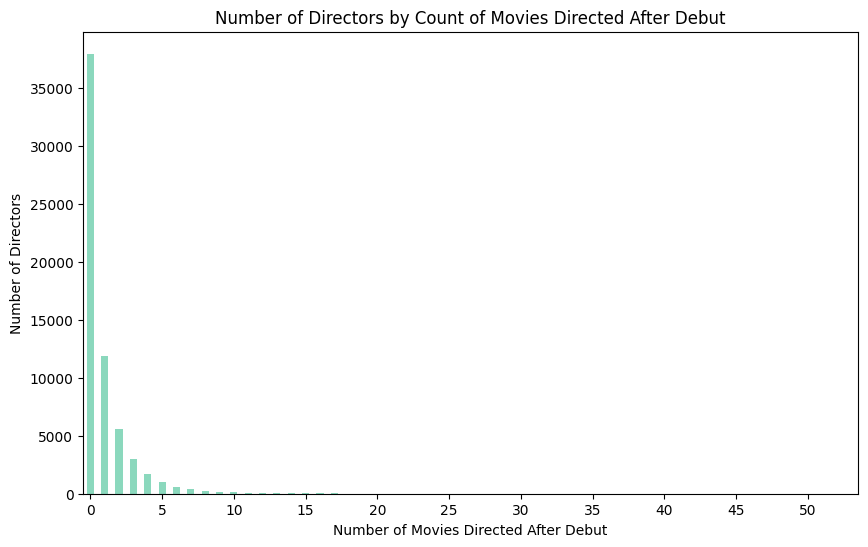

In [93]:
# Create a bar chart to visualize the number of movies directed by first-time directors after their debut
plt.figure(figsize=(10, 6))
director_counts_by_movie_number = post_debut_director_movies['movies_directed_after_first'].value_counts().sort_index()
director_counts_by_movie_number.plot(kind='bar', color='#8BD8BD')

# Adding labels and title
plt.title('Number of Directors by Count of Movies Directed After Debut')
plt.xlabel('Number of Movies Directed After Debut')
plt.ylabel('Number of Directors')

# Adjust the x-axis to show labels for every 5 movies for better readability
xticks = range(0, len(director_counts_by_movie_number), 5)
plt.xticks(ticks=xticks, labels=[str(i) for i in xticks], rotation=0)

plt.show()

Looks like the majority of directors did not direct another movie after their debut, aligning with the descriptive statistics above. 

## Background pre-debut

Some first-time directors might have worked on other movies in non-directing roles before they started directing. This prior experience might influence their career longevity as a director. Therefore, in this part of our analysis, we explore the extent and nature of their involvement in movie productions prior to their directing debut. We will create three variables to reflect a first-time director’s prior work experience, including whether they have worked on other movies in non-directing roles before they directed their first movie, and if so, how many movies and which role they took on in these movies.

In [75]:
# Filtering the principal dataset for entries related to our first-time directors
# This captures all the roles they have held in any film production, not just as directors
director_roles_pre_debut = df_principals[(df_principals['nconst'].isin(debut_directors_2003_2013['nconst']))]

# Merging this data with the movies dataset to associate each role with its corresponding release year
director_roles_pre_debut = director_roles_pre_debut[['tconst', 'nconst', 'category']].merge(movies[['tconst', 'startYear']], on='tconst', how='inner')

# Further merging with the debut directors dataset to include the year of each director's first movie
# This helps in identifying work done prior to their directorial debut
director_roles_pre_debut = director_roles_pre_debut.merge(debut_directors_2003_2013, on='nconst', how='left')

# Filtering for work before their directorial debut
# This step isolates their activities in the industry prior to becoming a director
pre_debut_work = director_roles_pre_debut[director_roles_pre_debut['startYear'] < director_roles_pre_debut['firstYear']]

# Excluding entries where their role was 'self' to focus on professional roles
pre_debut_work = pre_debut_work[pre_debut_work['category'] != "self"]

# Aggregating the data to count the number of movies and list the different roles each director held before their debut
pre_debut_experience = pre_debut_work.groupby('nconst').agg({
    'tconst': 'count', 
    'category': lambda x: list(set(x))
    }).rename(columns={'tconst': 'movie_count', 'category': 'roles'})

# Initializing a DataFrame to track each director's experience prior to their debut
directors_experience = pd.DataFrame({'nconst': directors_full_filmography['nconst']}).drop_duplicates()
directors_experience['had_prior_experience'] = 0  # Initializing with 0 (no experience)

# Merging with the pre_debut_experience data to get the movies count and different roles before debut
directors_experience = directors_experience.merge(pre_debut_experience, on='nconst', how='left')

# Filling missing values (NaNs) with 0 for directors without prior experience
directors_experience['movie_count'].fillna(0, inplace=True)

# Updating the 'had_prior_experience' flag to 1 for directors who had prior experience
directors_experience.loc[directors_experience['movie_count'] > 0, 'had_prior_experience'] = 1

Let's count the number of directors for each movie count.

In [123]:
directors_experience['movie_count'].value_counts().sort_index()

movie_count
0.0      52850
1.0       5774
2.0       1820
3.0        842
4.0        473
         ...  
106.0        1
112.0        1
124.0        1
160.0        1
163.0        1
Name: count, Length: 76, dtype: int64

Looks like the majority of first-time directors (84%) did not work in other movie productions before their directing debut.Let's creating a bar chart for those who did have prior experience to a sense of the variety and frequency of roles assumed by these directors.

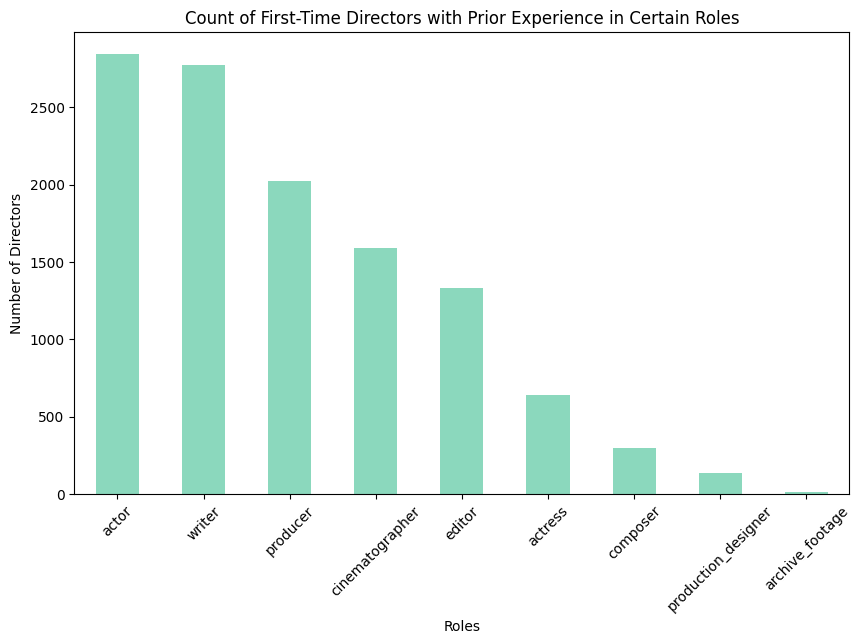

In [115]:
# Creating a bar chart to visualize the different roles taken by first-time directors before their debut

plt.figure(figsize=(10, 6))
# Flatten the list of roles and count each occurrence and create a bar chart
directors_experience.explode('roles')['roles'].value_counts().plot(kind='bar', color='#8BD8BD')

# Adding labels and title
plt.title('Count of First-Time Directors with Prior Experience in Certain Roles')
plt.xlabel('Roles')
plt.ylabel('Number of Directors')

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

Among first-time directors with prior industry experience, the most common roles are those of actors and writers. This  suggests a notable pathway into directing, where among people already in the film industry, those with substantial experience in acting or writing are more likely to transition into directing roles.

Finally, let's create a dataset to record the pre- and post-debut career of each director in our sample and save it for future analysis. 

In [127]:
# Merge the DataFrames on 'nconst'
directors_pre_post_debut_careers = directors_experience.merge(post_debut_director_movies, on='nconst', how='inner')

# Displaying the first few rows to get an overview of the data
directors_pre_post_debut_careers.head()

,nconst,had_prior_experience,movie_count,roles,firstYear,movies_directed_after_first
0,nm1131265,0,0.0,NaN,2004.0,2
1,nm1130611,0,0.0,NaN,2004.0,0
2,nm0290651,0,0.0,NaN,2003.0,0
3,nm0404033,0,0.0,NaN,2003.0,3
4,nm0000417,1,14.0,"[archive_footage, actor]",2005.0,1


In [126]:
# save the data for future analysis 
directors_pre_post_debut_careers.to_csv('directors_pre_post_debut_careers.csv', index=False)